In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

In [2]:
os.chdir('..')
path = os.getcwd()

In [3]:
path = 'C:\\Users\\Nico Janko\\Documents\\Data_Science\\OpenClassRoom\\Projet_7_opc'

In [4]:

train_df = pd.read_csv(path+'\\Project_files\\application_train.csv')
test_df = pd.read_csv(path+'\\Project_files\\application_test.csv')

In [5]:
print(train_df.info())
train_df.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

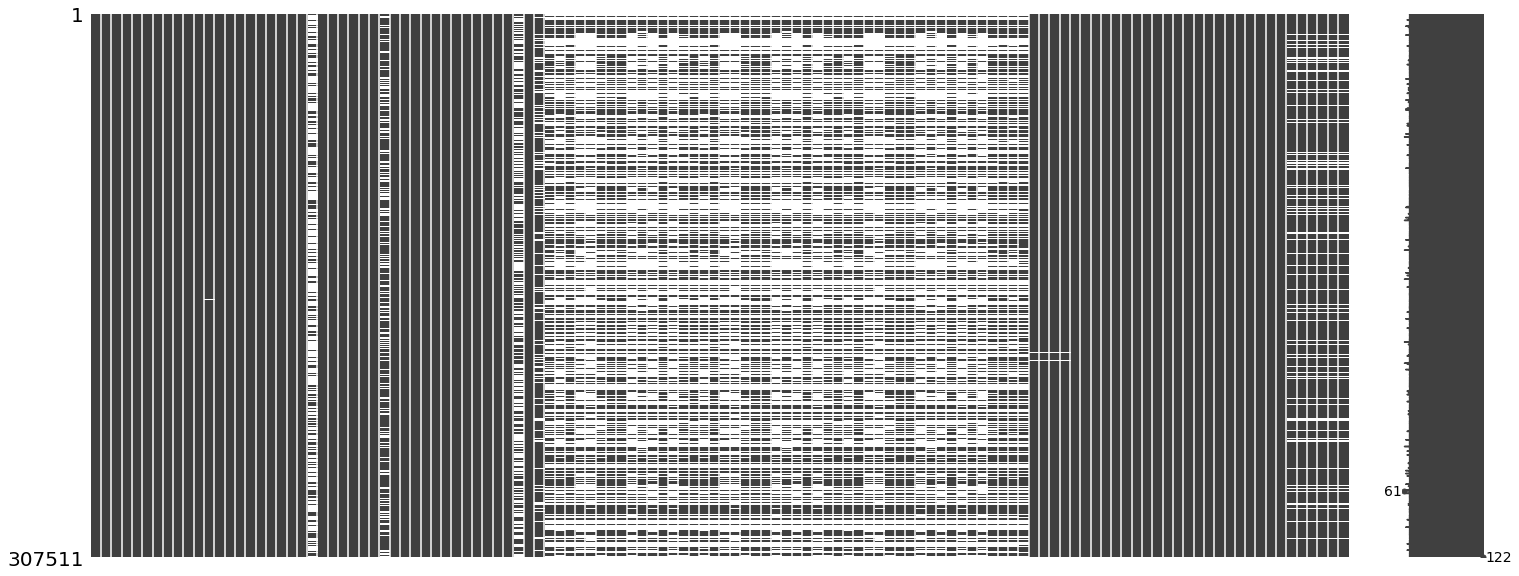

In [6]:
msno.matrix(train_df)

In [7]:
train_df['TARGET'].value_counts()/train_df.shape[0]

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [8]:
def preprocessing(df):
    #set the index as the id of the loan
    df.set_index('SK_ID_CURR')
    #OHE categorical features
    cat_df = df.select_dtypes(include = ['object'])
    df = df.select_dtypes(exclude = ['object'])
    ohe = OneHotEncoder(sparse = False)
    cat_df = ohe.fit_transform(cat_df)
    colnames = ohe.get_feature_names_out(ohe.feature_names_in_)
    cat_df = pd.DataFrame(cat_df, columns = colnames)
    df = df.join(cat_df)
    #extract target
    y = df['TARGET']
    df = df.drop(labels = 'TARGET', axis = 1)
    return df, y 
    
    

In [9]:
sample_df = train_df.sample(frac=0.2)
sample_df, sample_y = preprocessing(sample_df)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61502 entries, 204182 to 84306
Columns: 251 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_nan
dtypes: float64(211), int64(40)
memory usage: 120.3 MB


In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(sample_df, sample_y, random_state = 38)
scaler = StandardScaler()
xgboost = xgb.XGBClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ('classifier', xgboost)])
pipe.fit(xtrain, ytrain)
pipe.score(xtest, ytest)

0.9192247658688866

In [11]:
df, df_y = preprocessing(train_df)
xtrain, xtest, ytrain, ytest = train_test_split(df, df_y, random_state = 38)
pipe.fit(xtrain, ytrain)
pipe.score(xtest, ytest)

0.9193787559509873

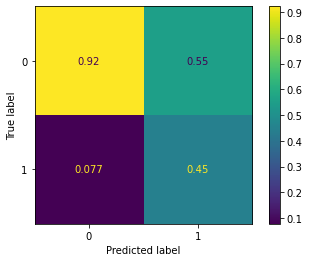

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

#pipe.set_params(classifier__n_estimators = grid.best_params_)

ypred = pipe.predict(xtest)

ConfusionMatrixDisplay.from_predictions(ytest, ypred, normalize = 'pred')

plt.show()

In [14]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70735
           1       0.45      0.04      0.07      6143

    accuracy                           0.92     76878
   macro avg       0.68      0.52      0.51     76878
weighted avg       0.88      0.92      0.89     76878



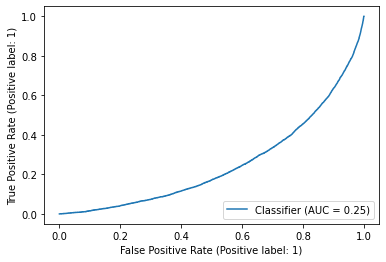

In [15]:
from sklearn.metrics import RocCurveDisplay

yproba = pipe.predict_proba(xtest)

RocCurveDisplay.from_predictions(ytest, yproba[:,1])

plt.show()

In [17]:
param_grid = {'classifier__n_estimators' : list(np.arange(50,250,50))}

grid = GridSearchCV(pipe, param_grid, verbose = 2)
grid.fit(sample_df, sample_y)

print('Best params on training set : {}'.format(grid.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ........................classifier__n_estimators=50; total time=  12.7s
[CV] END ........................classifier__n_estimators=50; total time=  12.1s
[CV] END ........................classifier__n_estimators=50; total time=  11.2s
[CV] END ........................classifier__n_estimators=50; total time=  11.5s
[CV] END ........................classifier__n_estimators=50; total time=  11.3s
[CV] END .......................classifier__n_estimators=100; total time=  20.4s
[CV] END .......................classifier__n_estimators=100; total time=  20.7s
[CV] END .......................classifier__n_estimators=100; total time=  21.6s
[CV] END .......................classifier__n_estimators=100; total time=  20.6s
[CV] END .......................classifier__n_estimators=100; total time=  20.7s
[CV] END .......................classifier__n_estimators=150; total time=  30.0s
[CV] END .......................classifier__n_est

In [18]:
pipe.set_params(classifier__n_estimators = grid.best_params_['classifier__n_estimators'])

pipe.fit(xtrain, ytrain)
pipe.score(xtest, ytest)

0.9196389084003226

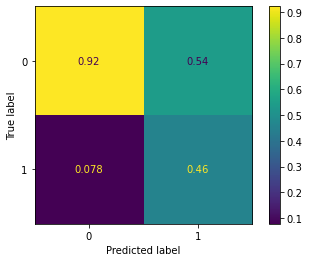

<Figure size 432x288 with 0 Axes>

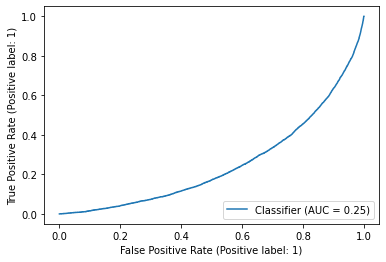

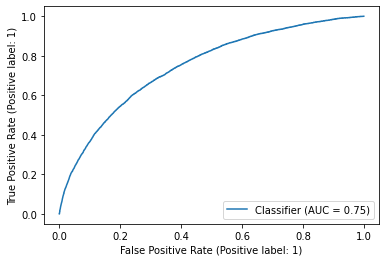

In [19]:
ypred = pipe.predict(xtest)

ConfusionMatrixDisplay.from_predictions(ytest, ypred, normalize = 'pred')

plt.show()
plt.clf()
RocCurveDisplay.from_predictions(ytest, yproba[:,0])
plt.show()
RocCurveDisplay.from_predictions(ytest, yproba[:,1])
plt.show()

In [21]:
print('prout')

prout
